The goal here is to evaluate the errors introduced adversarial training by a bit-wise comparison of the original weight values with the modified values.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
orig_weights = np.load('original_weights.npy')
modified_weights = np.load('modified_weights.npy')

In [3]:
def compute_minAndMax(list_arrays):
    '''
    Function to find the smallest and largest elements 
    in a list of numpy arrays
    '''
    min_val = np.inf
    max_val = -np.inf
    for arr in list_arrays:
        if arr.min() < min_val:
            min_val = arr.min()
        if arr.max() > max_val:
            max_val = arr.max()
    return min_val, max_val

In [5]:
def scale_weights(list_weightArrays, scale_func):
    '''
    scale the weight values so that they are in [0-1)
    '''
    list_scaledWeightArrays = []
    for arr in list_weightArrays:
        scaledArray = scale_func(arr)
        list_scaledWeightArrays.append(scaledArray)
    return list_scaledWeightArrays

In [ ]:
def convert_toBinary(dec_frac):
    '''Function to convert a decimal fraction into binary.
    Returns a list of 0s and 1s corresponding to the 
    binary representation of "dec_frac"'''
    binRep = []
    for i in range(8):
        dec_frac = dec_frac * 2
        binRep.append(int(dec_frac))
        if int(dec_frac) == 1:
            dec_frac -= 1
    return binRep

In [16]:
def convert_seqToBinary(listArrays):
    '''Function to convert the list of arrays into binary'''
    binListArrays = []
    for arr in listArrays:
        binArray = []
        for val in np.nditer(arr):
            binArray.append(convert_toBinary(val))
        binListArrays.append(binArray)
    return binListArrays

In [15]:
def compute_bitErrorRate(list_origWeights, list_modifiedWeights):
    '''
    scales the values to range 0-N, then computes the xor for each pair of values
    '''
    # We need to consider both the original weights as well as the modified 
    # weights while finding the minimum and maximum element, so that the 
    # computed range encompasses all the weight values.
    orig_min, orig_max = compute_minAndMax(list_origWeights)
    modified_min, modified_max = compute_minAndMax(list_modifiedWeights)
    min_val = min(orig_min, modified_min)
    # Since the range is [0-1), the max_val can be set to be slightly larger 
    # than the maximum value so that all values are in [0-1)
    max_val = max(orig_max, modified_max) + 1e-5
    scale_func = lambda x : (x - min_val)/(max_val - min_val)
    scaled_origWeights = scale_weights(list_origWeights, scale_func)
    scaled_modifiedWeights = scale_weights(list_modifiedWeights, scale_func)
    list_bitErrorRates = []
    for orig_arr, modified_arr in zip(scaled_origWeights, scaled_modifiedWeights):
        pass
    #return list_bitErrorRates
    return scaled_origWeights, scaled_modifiedWeights

In [7]:
compute_bitErrorRate(orig_weights, modified_weights)

Original range:  -2.0573716 1.2827647


[]

In [8]:
def measure_noise(orig_values, modified_values):
    list_noiseValues = []
    for orig_arr, modified_arr in zip(orig_values, modified_values):
        # error_arr is the element-wise difference of all values in the array
        error_arr = orig_arr - modified_arr
        list_noiseValues.append(error_arr)
    return list_noiseValues
adversarialNoise = measure_noise(orig_weights, modified_weights)
compute_minAndMax(adversarialNoise)

(-0.0020616278, 0.0020405427)

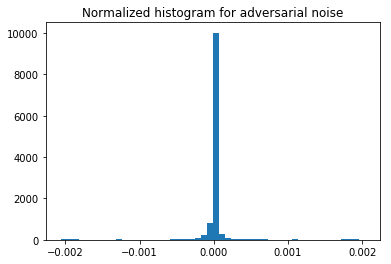

In [9]:
# Need to store as an array of arrays for plotting the values, a list
# is not flexible enough
# Compare the adversarial noise with random gaussian noise
flattened_adversarialNoise = np.array([])
for arr in adversarialNoise:
    flattened_adversarialNoise = np.append(flattened_adversarialNoise, np.reshape(arr, (-1,)))
plt.hist(flattened_adversarialNoise, 50, density=True, stacked=True)
plt.title('Normalized histogram for adversarial noise')
#plt.show()

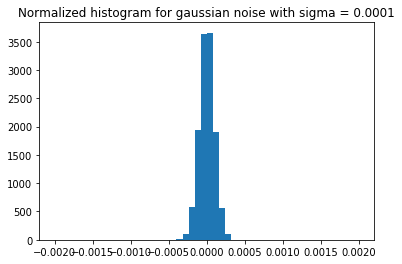

In [10]:
mu, sigma = 0, 0.0001 # mean and standard deviation
s = np.random.normal(mu, sigma, 10000)
counts, bins, _ = plt.hist(s, 50, range=(-0.002, 0.002), density=True)
plt.title('Normalized histogram for gaussian noise with sigma = 0.0001')
#plt.show()

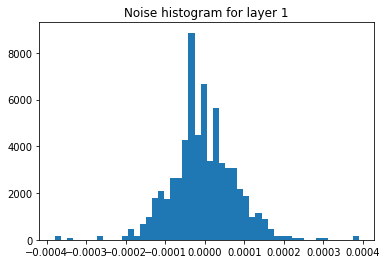

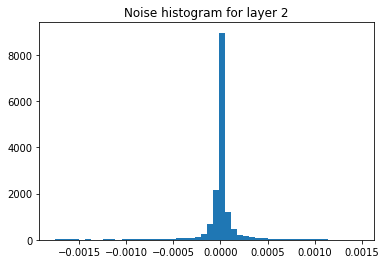

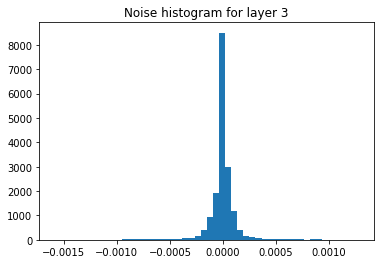

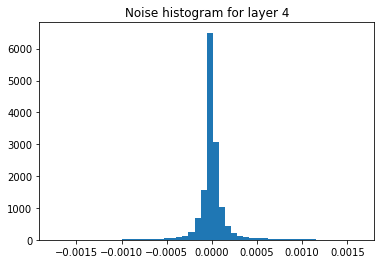

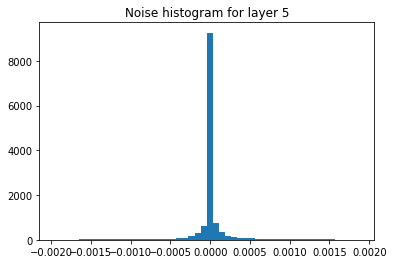

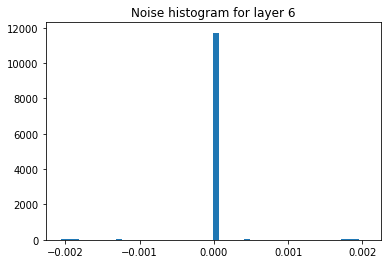

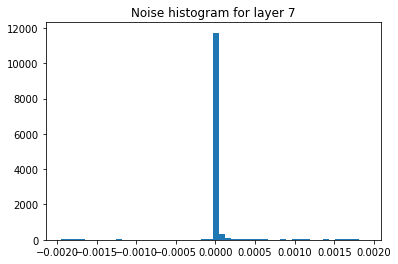

In [11]:
# Plot noise values for all the layers
for i, arr in enumerate(adversarialNoise):
    plt.hist(np.reshape(arr, (-1,)), 50, density=True, stacked=True)
    plt.title("Noise histogram for layer " + str(i+1))
    #plt.show()